In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd
import re
import matplotlib

In [4]:
font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)
def degree(g, nodes=None, as_list=True):
    deg = dict(g.degree())
    if nodes: deg = dict(g.degree(nodes))
    
    if as_list: return list(deg.values())
    return deg

def degree_plot(g, nodes=None, filename=None, title=''):
    deg = degree(g, nodes=nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.figure(figsize=[15,10])
    plt.plot(means, freqs, ".", markersize=20)
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    if filename: plt.savefig('plots/%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()
    
    # LOG LOG PLOT
    plt.figure(figsize=[15,10])
    plt.loglog(means, freqs, ".", markersize=20)
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    if filename: plt.savefig('plots/log_%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()

## Motivation
### What is your dataset?
The dataset used in this project comes from the data provided for the Yelp Dataset Challenge. This dataset consists of about 1.5 million users and about 200 thousand businesses from North America.  Additionally the dataset includes just under 6 million reviews, made by users of the Yelp service, to businesses. The businesses included in the dataset are both restaurants as well as businesses offering other services, such as postal delivery. 

### Why did you choose this/these particular dataset(s)?
 It is interesting to study the patterns in peoples' opinions and behaviour and with a dataset as large as the yelp dataset, this is made possible.
### What was your goal for the end user's experience?
The purpose of this project is to investigate properties of Yelp’s Elite users. For this paper, the focus will lie on Yelp’s two primary claims about their Elite users:

Yelp states that its Elite users have high connectivity, which means that they are connected with many other users and interact often with members of their Yelp community. 

Yelp claims that its Elite users make up the “true heart of the Yelp community.” Third, Yelp claims that its users have high contribution, which means that the user has made a large impact on the site with meaningful and high-quality reviews. 

The first goal of our project is to analyze whether the above claims about Yelp’s Elite users are quantifiably valid. For this, we will specify several characteristics which we expect Elite users to have based on these claims. We will then perform analyses on Yelp’s dataset in order to determine whether these properties are truly represented among the Elite users. The secondary goal of our project is to find which properties are most indicative of Elite status on Yelp. 

The analyses for the first goal can be used for this purpose as well. This kind of information may be useful for those who are interested in becoming Elite members on Yelp. In order to become a member of the “Elite squad,” a user must go through an application process. Despite the suggestions presented above, Yelp doesn’t provide any specific criteria on exactly what characteristics a user must have to become Elite. The mystery behind the selection process for Elite users is well-documented.




## Basic stats. Let's understand the dataset better
### Write about your choices in data cleaning and preprocessing
- Mis-formatted JSON to valid JSON

In [34]:
import pandas as pd
def cleanup(N, dataset, chunk_size=100000):
    '''
    Cleans up a JSON file by adding a trailing comma to each line,
    which is missing from the Yelp dataset files.
    A chunk size must be specified, since all the lines in the data
    files cannot be stored in memory at the same time, due to being very large!
    '''
    for k in range(N):
        dirty_path = 'yelp_dataset/yelp_academic_dataset_%s.json' % dataset
        clean_path = "cleaned/%s%i.json" % (dataset, k)
        dirty_file = open(dirty_path, "r")
        clean_file = open(clean_path, "w")


        start = chunk_size * k
        end = chunk_size * (k+1)

        content = ''
        i = 0
        for line in dirty_file:
            if i == end:
                break
            elif i >= start:
                s = line.replace('\n', ',\n')
                content += s
            i += 1
        if content:
            payload = '{"data" : \n[%s]}' % (content[:-2] + '\n')
            clean_file.write(payload)
        else:
            print("No more content.")
    
    print('Iteration', k, 'done')
    
def read_json_to_df(N, dataset):
    # Create dataframe from JSON files
    df_matrix = [None] * N
    for i in range(N):
        path = "cleaned/business%i.json" % i
        df_matrix[i] = pd.DataFrame(list(pd.read_json(path).data))
    return pd.concat(df_matrix)

# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

### Get all restaurants from Toronto

In [ ]:
# Clean business JSON files
N = 2 # There are about 200k restaurants, therefore 2 chunks of 100k elements is sufficient
dataset = 'business'
cleanup(N, dataset)

# Make dataframe from JSON data
df = read_json_to_df(N, dataset)

# Restaurants will contain the keywords 'restaurant' 
# and/or 'food' in the 'category' attribute.
keywords = ['restaurant', 'food']
idx = df.categories.str.lower().str.contains("|".join(keywords)).fillna(False)
rest = df[idx]


# Only include Toronto restaurants
rest.city = rest.city.str.lower()
rest = rest[rest.city == 'toronto']

# Drop attributes irrelevant to the analysis
rest = rest.drop(['city', 'attributes', 'categories', 'address', 'neighborhood', 'is_open', 'hours'], axis=1)

# Save dataset to CSV
rest.to_csv('toronto2/toronto_restaurants.csv', header=False)

### Get all reviews from Toronto

In [ ]:
# Clean business JSON files
N = 60 # There are about 6M reviews, therefore 60 chunks of 100k elements is sufficient
dataset = 'review'
cleanup(N, dataset)

# Make dataframe from JSON data
df = read_json_to_df(N, dataset)

# Filter out reviews of businesses outside Toronto
reviews = df[df.business_id.isin(rest.business_id)]

# Drop attributes irrelevant to the analysis
reviews = reviews.drop(['cool', 'funny', 'useful'], axis=1)

# Save dataset to CSV
reviews.to_csv('toronto2/toronto_reviews.csv')

### Get all users in the Toronto reviews

In [ ]:
# Clean business JSON files
N = 30 # A guess
dataset = 'user'
cleanup(N, dataset)

# Make dataframe from JSON data
df = read_json_to_df(N, dataset)

# Filter out users not in the Toronto reviews
toronto_users = df[df.user_id.isin(reviews.user_id)]

# Drop attributes irrelevant to the analysis
toronto_users = toronto_users.drop(['compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
     'funny', 'fans'], axis=1)

# Save to CSV
toronto_users.to_csv('toronto/toronto_users.csv', index=False)

### Dataset stats
- Reviews: ~6 million
- Users: Many
- Businesses: ~200,000

For this project the restaurants in Toronto were the main focus, as Toronto is a big city with more than a sufficient amount of data to perform a serious analysis, but small enough for various graph algorithms to be carried out. The users considered in this project were all the users who left a review on a business in Toronto.

- Period: March 1st 2008 to August 1st 2018
- Reviews: ~380,000
- Users: ~85,000
- Elite users hereof: ~7,500
- Restaurants: ~10,000

## Tools, theory and analysis. Describe the process of theory to insight

### Talk about how you've worked with text, including regular expressions, unicode, etc.

### Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
* NetworkX for creating the graphs for analysis. 
* Centrality measures: Degree and eigenvalue. Degree tells us how popular a user is in terms of friends, or how many reviews they made.
* Clustering coefficient: How connected is the graph on average?
* Degree distributions: Do the network degrees obey power law distributions?


#### Modelling the social network
The social network was created by extracting the friends of each user who made a review on a Toronto-based restaurant, and then creating a link between each user. Some users in the social network will not have placed a review on a Toronto-based restaurant, and will only be in the network due to their friendship with someoneone who has. 

#### Modelling the review network
The Toronto Yelp review network was modelled as an undirected graph, containing user nodes where the edges between two user nodes represent the fact two users have reviewed the same restaurant. 

#### Most connected subcomponent
Detecting how important the elite users were for the network was done by removing them from the network in small chunks, and then observing how the largest connected subcomponent shrinks. The elite users were deleted based on their degree centrality.

### How did you use the tools to understand your dataset?

* NetworkX for creating the graphs for analysis. 
* Centrality measures: Degree and eigenvalue. Degree tells us how popular a user is in terms of friends, or how many reviews they made.
* Clustering coefficient: How connected is the graph on average?
* Degree distributions: Do the network degrees obey power law distributions?
* Plotting: We tried drawing the networks, but they were simply too large in terms of nodes and edges.

In [32]:
# Constant Strings
USER = 'user'
ELITE_USER = 'elite_user'
BIZ = 'biz'

# Read in data
biz = pd.read_csv('toronto/toronto_biz.csv')
user = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.concat([
    pd.read_csv('toronto/toronto_reviews_1.csv'),
    pd.read_csv('toronto/toronto_reviews_2.csv'),
    pd.read_csv('toronto/toronto_reviews_3.csv'),
    pd.read_csv('toronto/toronto_reviews_4.csv')
])

# Extract elite users
elite_user = user[~user.elite.str.contains('None')]
elite_ids = set(elite_user.user_id)

print('#Reviews:', len(reviews))
print('#Users:', len(set(reviews.user_id)))
print('#Elite users:', len(elite_user))
print('#Businesses:', len(set(reviews.business_id)))

#Reviews: 379875
#Users: 84624
#Elite users: 7499
#Businesses: 9678


### The Toronto Yelp friends Network
The Toronto Yelp friends network was used to model the friendships of users, whom have reviewed one or more restaurants in Toronto.

In [51]:
# Create friend list
users_with_friends = user[user.friends != 'None']
friend_list = dict()
for row in users_with_friends.itertuples():
    friend_list[row.user_id] = re.split(r',', row.friends)

In [52]:
len(friend_list)

49362

In [35]:
social_network = nx.Graph()
for uid in users_with_friends.user_id:
    a = Node(uid, ELITE_USER if uid in elite_ids else USER)
    for fid in friend_list[uid]:
        b = Node(fid, ELITE_USER if fid in elite_ids else USER)
        social_network.add_edge(a, b)

In [36]:
N,L = len(social_network.nodes()), len(social_network.edges())

print('Nodes:', len(social_network.nodes()))
print('Edges:', len(social_network.edges()))

Nodes: 1552431
Edges: 3214980


In [37]:
user_nodes = [n for n in list(social_network.nodes()) if n.Type == USER]
elite_nodes = [n for n in list(social_network.nodes()) if n.Type == ELITE_USER]

In [39]:
print('Regular User Nodes:', len(user_nodes))
print('Elite User Nodes:', len(elite_nodes))
print('Elite to regular user ratio:', len(elite_nodes) / len(user_nodes))

Regular User Nodes: 1544962
Elite User Nodes: 7469
Elite to regular user ratio: 0.004834423112024762


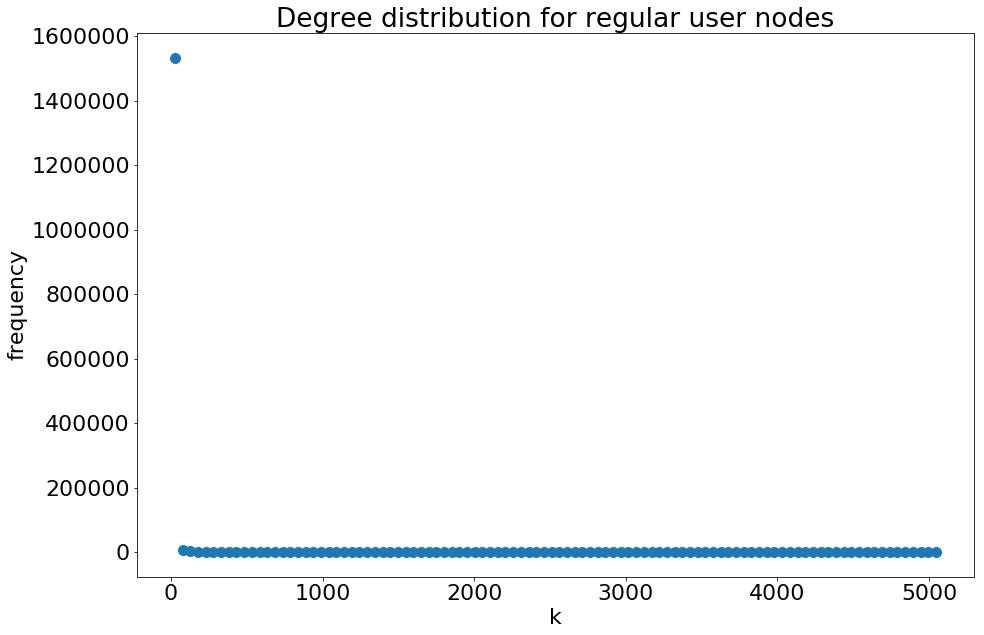

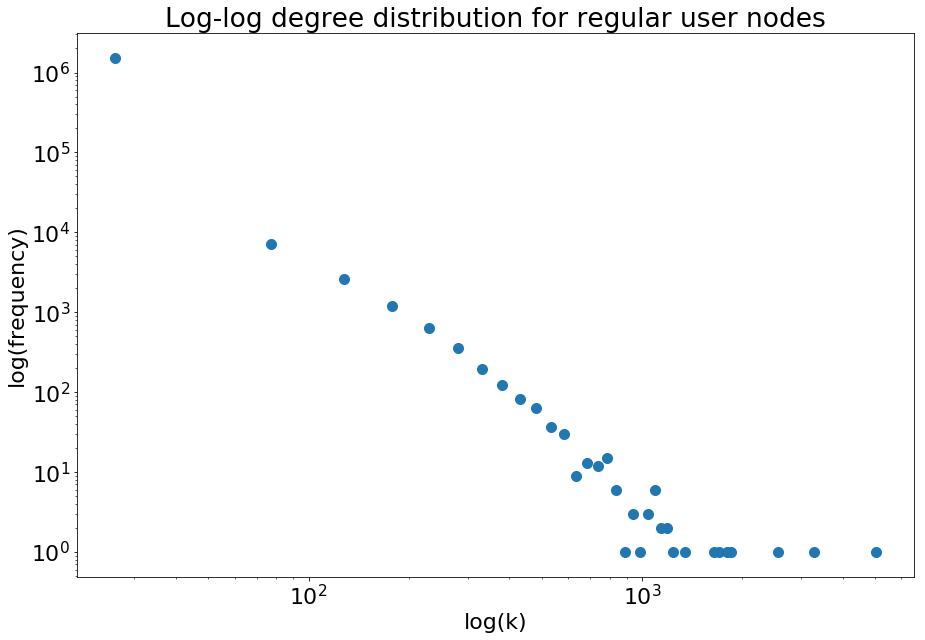

In [42]:
degree_plot(social_network, nodes=user_nodes, title="regular user nodes", filename='degree_social_regular')

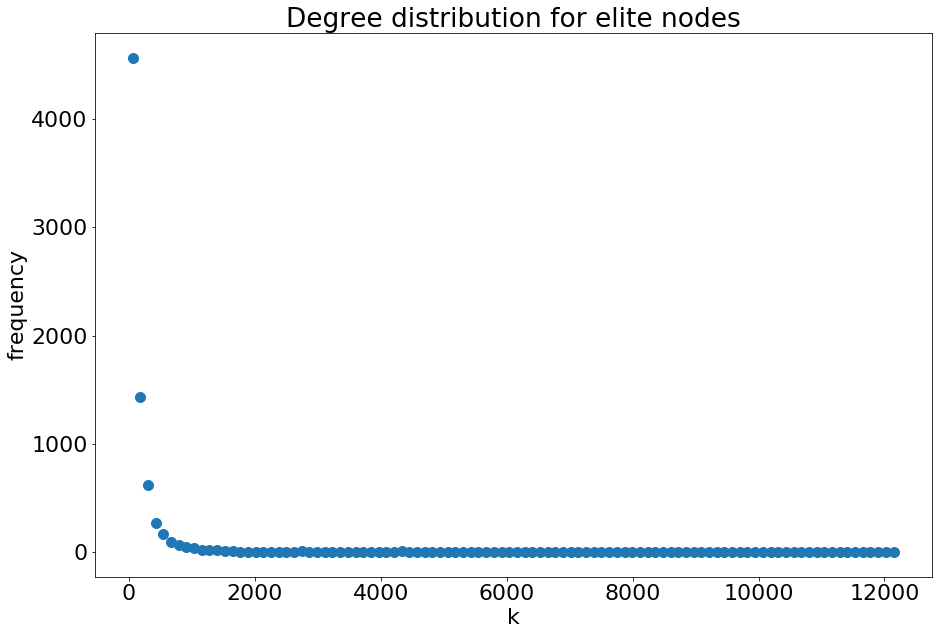

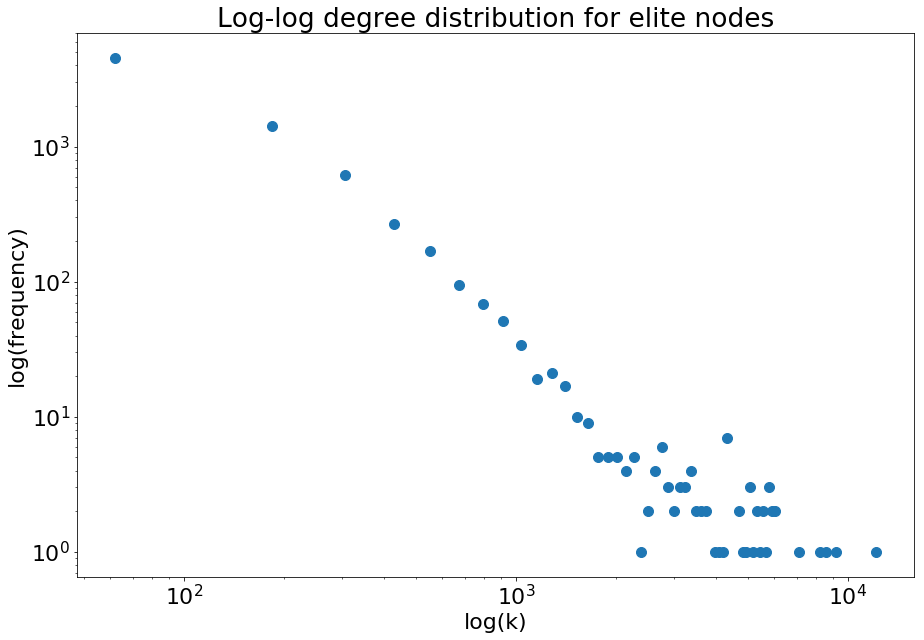

In [41]:
degree_plot(social_network, nodes=elite_nodes, title="elite nodes", filename='degree_social_elite')

In [43]:
L = max(nx.connected_component_subgraphs(social_network), key=len)
print("Nodes in largest subcomponent:", len(L.nodes()))
print("Edges in largest subcomponent:", len(L.edges()))

Nodes in largest subcomponent: 1534169
Edges in largest subcomponent: 3202099


In [ ]:
ev = nx.eigenvector_centrality_numpy(social_network)
ev_avg_elite = np.mean([ev[node]for node in ev if node.Type == ELITE_USER])
ev_avg_reg = np.mean([ev[node]for node in ev if node.Type == USER])
ev_avg_all = np.mean([ev[node]for node in ev if node.Type == USER or node.Type == ELITE_USER])

In [ ]:
ev_avg_elite, ev_avg_reg, ev_avg_all

#### Degree Centrality

In [ ]:
dg = nx.degree_centrality(social_network)
dg_avg_elite = np.mean([dg[node]for node in dg if node.Type == ELITE_USER])
dg_avg_reg = np.mean([dg[node]for node in dg if node.Type == USER])
dg_avg_all = np.mean([dg[node]for node in dg if node.Type == USER or node.Type == ELITE_USER])

In [ ]:
dg_avg_elite, dg_avg_reg, dg_avg_all

### Robustness analysis of the social network

In [55]:
def robustness_analysis(graph, nodes, one_percent_of_users):
    k = 100
    random.shuffle(nodes)

    # Initialize array for LCC sizes
    lcc_values = np.zeros(k)

    # Start loop
    for i in range(k):
        print(str(i) + " percent removed.")
        print("Network size: " + str(len(graph)))

        # Compute largest connected subcomponent
        mcc = len(max(nx.connected_component_subgraphs(graph), key=len))
        lcc_values[i] = mcc
        print("Largest connected component: " + str(mcc))

        # Remove 1 percent of users, randomly chosen
        for j in range(one_percent_of_users):
            node = nodes.pop()
            graph.remove_node(node)
            
    return lcc_values

In [ ]:
# The number of users to remove each round in the robustness analysis
one_percent = int(len(elite_user)*0.01)

# The robustness analysis takes over an hour, run at your own risk
lcc_random = robustness_analysis(social_network, social_network.nodes(), one_percent)
lcc_regular = robustness_analysis(social_network, social_network.nodes(), one_percent)
lcc_elite = robustness_analysis(social_network, social_network.nodes(), one_percent)

In [59]:
# We have saved the result in files, which can be read here instead.
lcc_random = pd.read_csv('toronto/LCC_random.txt', header=None, names=['data'])
lcc_reg = pd.read_csv('toronto/LCC_regular.txt', header=None, names=['data'])
lcc_elite = pd.read_csv('toronto/LCC_elite.txt', header=None, names=['data'])

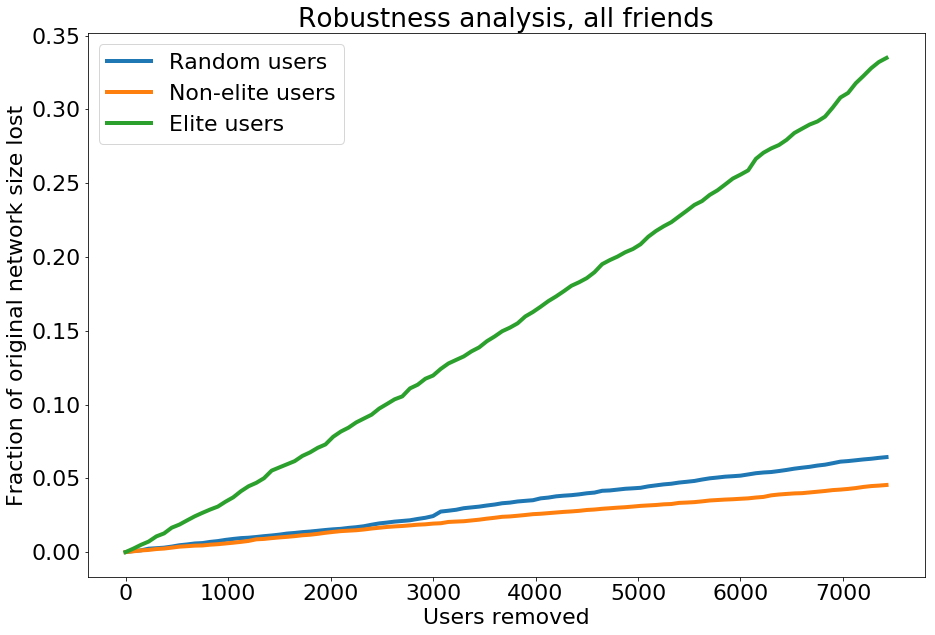

In [64]:
x_ax = 75 * np.arange(0,100)
plt.figure(figsize=[15,10])
plt.plot(x_ax, 1 - lcc_random.data / lcc_random.data.max(), linewidth=4)
plt.plot(x_ax, 1 - lcc_reg.data / lcc_reg.data.max(), linewidth=4)
plt.plot(x_ax, 1 - lcc_elite.data / lcc_elite.data.max(), linewidth=4)
plt.legend(['Random users', 'Non-elite users', 'Elite users'])
plt.xlabel('Users removed')
plt.ylabel('Fraction of original network size lost')
plt.savefig('plots/robustness_plot.svg', format='svg', bbox_inches="tight")
plt.title('Robustness analysis, all friends')
plt.show()

### The Toronto Review Network
The Toronto Yelp review network was modelled as an undirected graph, containing user nodes where the edges between two user nodes represent the fact two users have reviewed the same restaurant. 

### Create the review network

In [8]:
# Create a NetworkX graph for the review network
review_network = nx.Graph()

# For each review, create a node for the user and business and a link between them
for r in reviews.itertuples():
    a = Node(r.user_id, ELITE_USER if r.user_id in elite_ids else USER)
    b = Node(r.business_id, BIZ)
    review_network.add_edge(a, b, weight=r.stars)

# Show the number of nodes and edges
print('Nodes:', len(review_network.nodes()))
print('Edges:', len(review_network.edges()))

Nodes: 94291
Edges: 379875


### Review network measures

In [9]:
# Separate nodes based on their type
review_biz_nodes = [n for n in list(review_network.nodes()) if n.Type == BIZ]
review_user_nodes = [n for n in list(review_network.nodes()) if n.Type == USER]
review_elite_nodes = [n for n in list(review_network.nodes()) if n.Type == ELITE_USER]

#### Regular user degree distributions

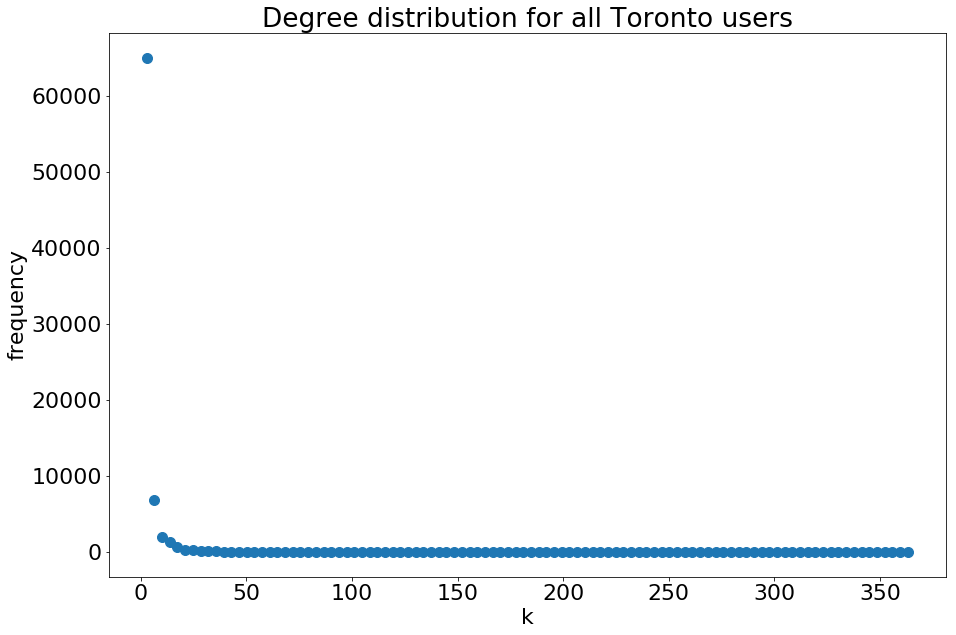

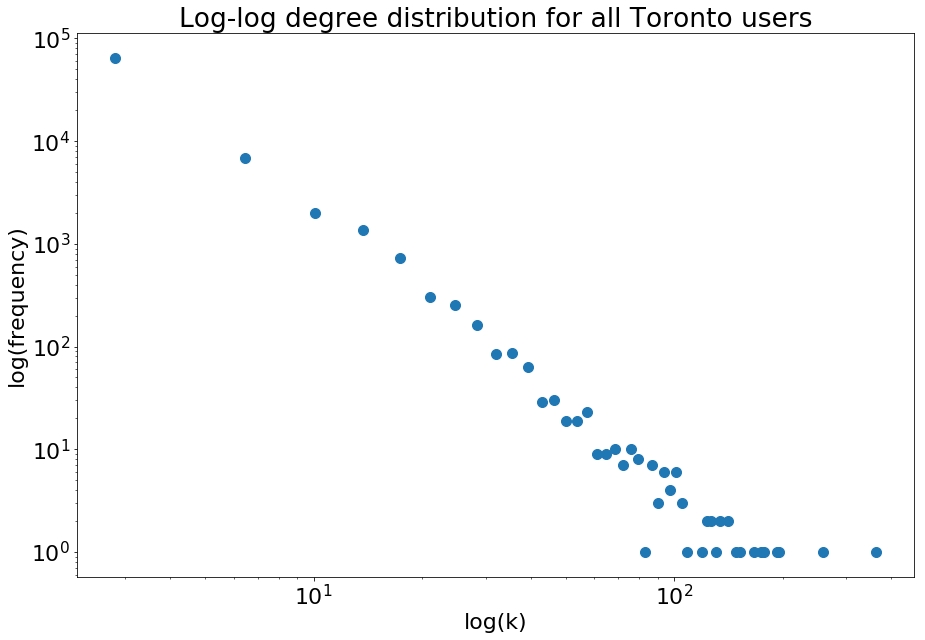

In [10]:
degree_plot(review_network, review_user_nodes, title="all Toronto users", filename='reviews_degree_normal_users')

#### Elite user distribution

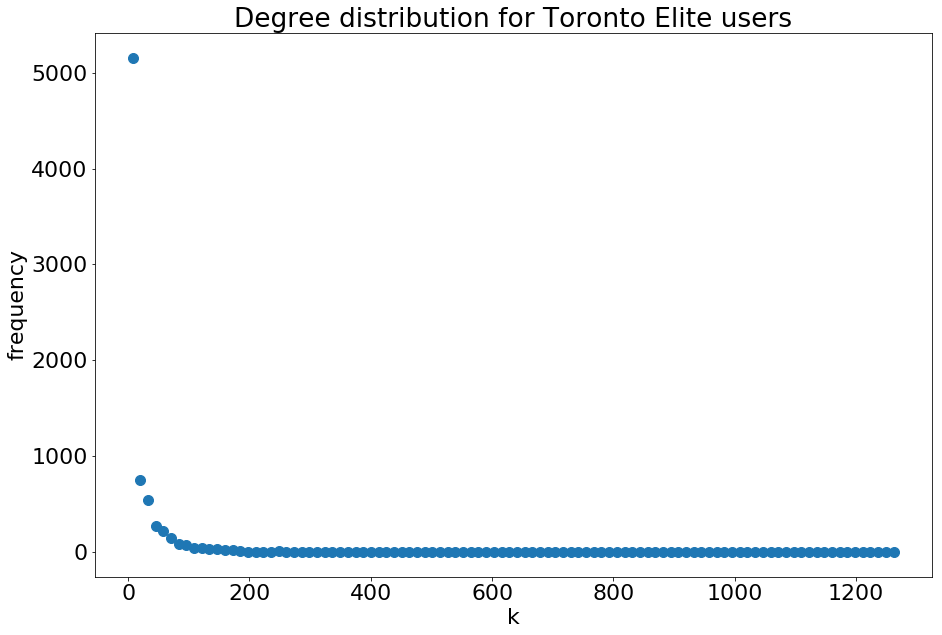

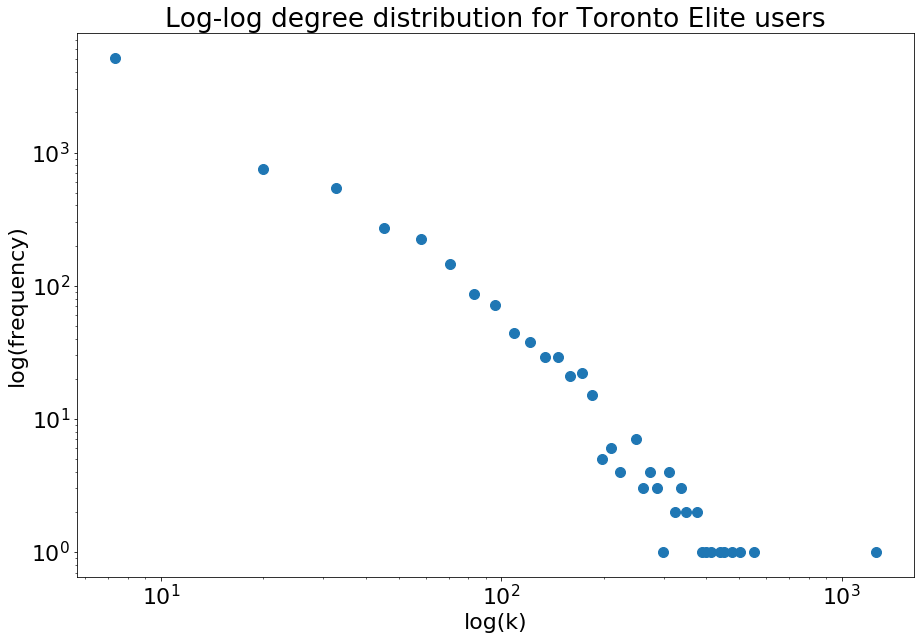

In [11]:
degree_plot(review_network, review_elite_nodes, title="Toronto Elite users", filename='reviews_degree_elite_users')

#### Restaurant degree distributions

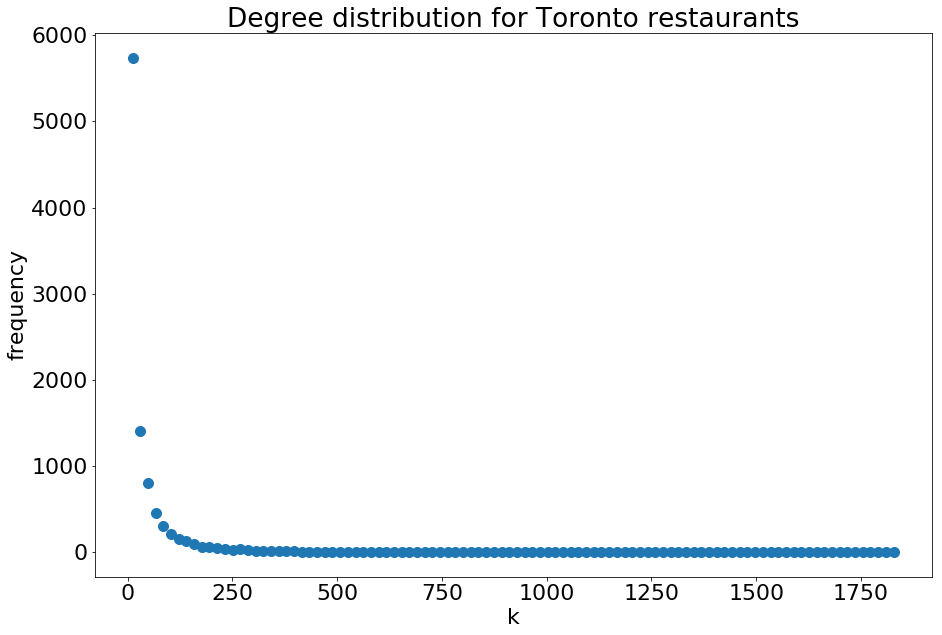

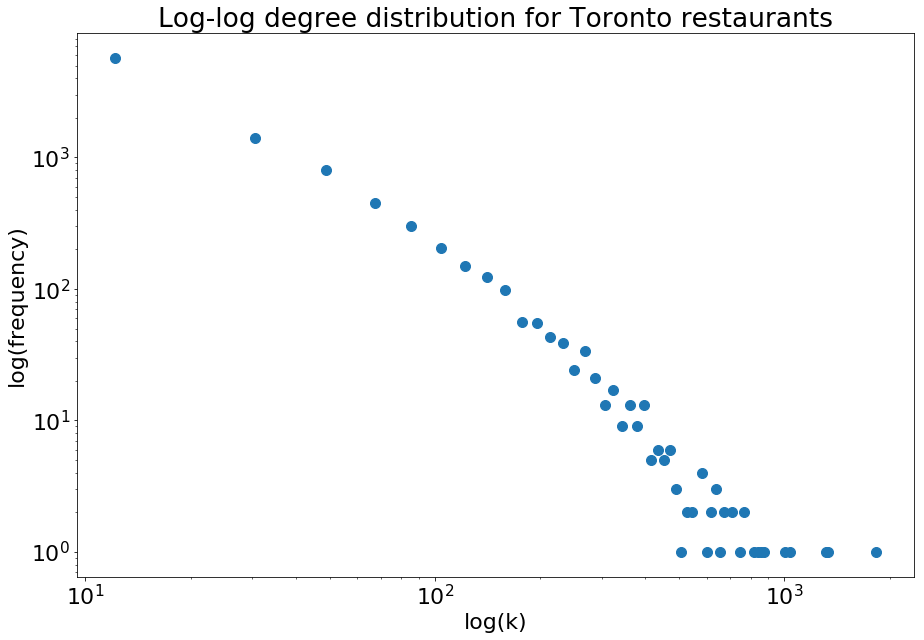

In [12]:
degree_plot(review_network, review_biz_nodes, title="Toronto restaurants", filename='reviews_degree_all_biz')

#### Centrality measures
* Degree centrality is a basic measure for the number of reviews a user has given, and for a restaurant it represents the number of reviews the restaurant has been given.
* Eigenvector centrality for a user node indicates to which degree they have reviewed restaurants with many reviews, and for a restaurant the measure represents how many reviews come from users who themselves have given a lot of reviews.

In [13]:
# Degree centrality
deg = nx.degree(review_network)
deg_elite_user = [deg[n] for n in deg if n.Type == ELITE_USER]
deg_user = [deg[n] for n in deg if n.Type == USER]
elite_avg_deg = np.mean(deg_elite_user)
user_avg_deg = np.mean(deg_user)
all_user_deg = np.mean(deg_elite_user + deg_user)

# Show results
print('Normal user mean degree centrality', user_avg_deg)
print('Elite user mean degree centrality', elite_avg_deg)
print('All users mean degree centrality', all_user_deg)
ratio = elite_avg_deg / user_avg_deg
print('Ratio degree (Elite : Normal): %.2f' % ratio)

Normal user mean degree centrality 3.0597274271561394
Elite user mean degree centrality 19.19215895452727
All users mean degree centrality 4.489446440389524
Ratio degree (Elite : Normal): 6.27


On average, elite users have over 6 times as many friend connections on Yelp, as regular users

In [14]:
# Eigenvalue centrality
ev = nx.eigenvector_centrality_numpy(review_network)
ev_elite_user = [ev[n] for n in ev if n.Type == ELITE_USER]
ev_user = [ev[n] for n in ev if n.Type == USER]
elite_avg_ev = np.mean(ev_elite_user)
user_avg_ev = np.mean(ev_user)
all_user_ev = np.mean(ev_elite_user + ev_user)

# Show results
print('Normal user mean EV centrality', user_avg_ev)
print('Elite user mean EV centrality', elite_avg_ev)
print('All users mean EV centrality', all_user_ev)
ratio = elite_avg_ev / user_avg_ev
print('Ratio EV (Elite : Normal): %.2f' % ratio)

Normal user mean EV centrality 0.0005151721690592373
Elite user mean EV centrality 0.0034574370628518815
All users mean EV centrality 0.0007759271614785319
Ratio EV (Elite : Normal): 6.71


### Eigenvalue centrality vs average user rating

The eigenvalue centrality has already been calculated beforehand, and is stored in the user dataframe.

In [ ]:
# Create new column in the user dataframe
user['ev'] = 0
ev_user = {n.Data: ev[n] for n in ev if (n.Type == ELITE_USER) or (n.Type == USER)}

# Insert the eigenvalue of the user in the dataframe. This takes several minutes...
i = 1
p = int(len(ev_user) / 100)
for k in ev_user:
    if  i % p == 0: print('%i percent done' % (i/p))
    eigenvalue = ev_user[k]
    user.loc[user.user_id == k, 'ev'] = eigenvalue
    i += 1

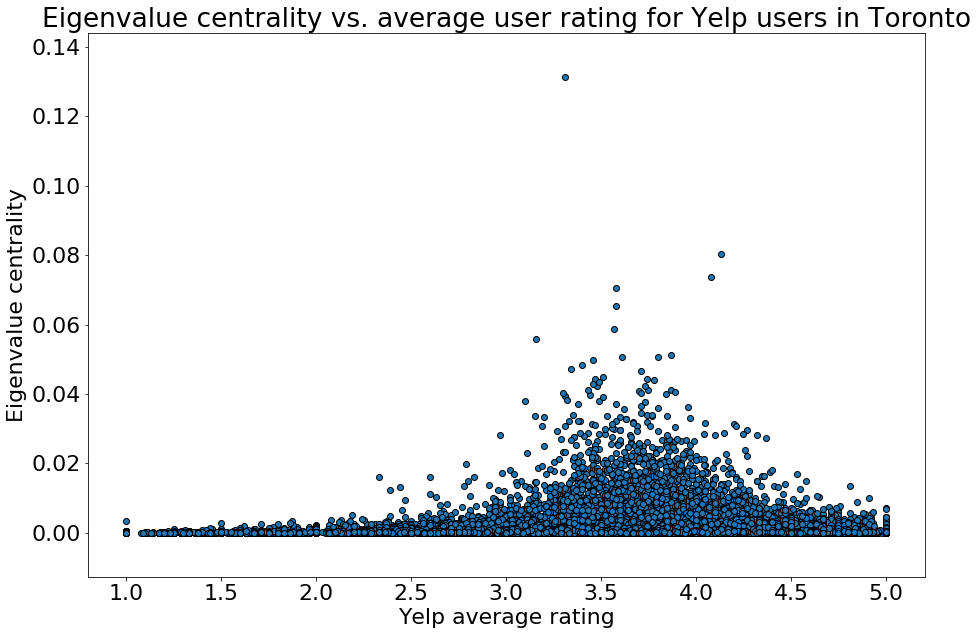

In [15]:
# Plot the eigenvalue of the user vs. the average rating the user
plt.figure(figsize=[15,10])
plt.scatter(user.average_stars, user.ev, edgecolors='black')
plt.xlabel('Yelp average rating')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality vs. average user rating for Yelp users in Toronto')
plt.savefig('plots/user_rating_ev.svg', format='svg', bbox_inches="tight")
plt.show()

### Restaurants and eigenvalue centrality

The eigenvalue centrality has already been calculated beforehand, and is stored in the biz dataframe.

In [ ]:
ev_biz = {n.Data: ev[n] for n in ev if n.Type == BIZ}
deg_biz = {n.Data: deg[n] for n in deg if n.Type == BIZ}
biz['ev'] = 0.0

for k in ev_biz:
    eigenvalue = ev_biz[k]
    biz.loc[biz.business_id == k, 'ev'] = eigenvalue

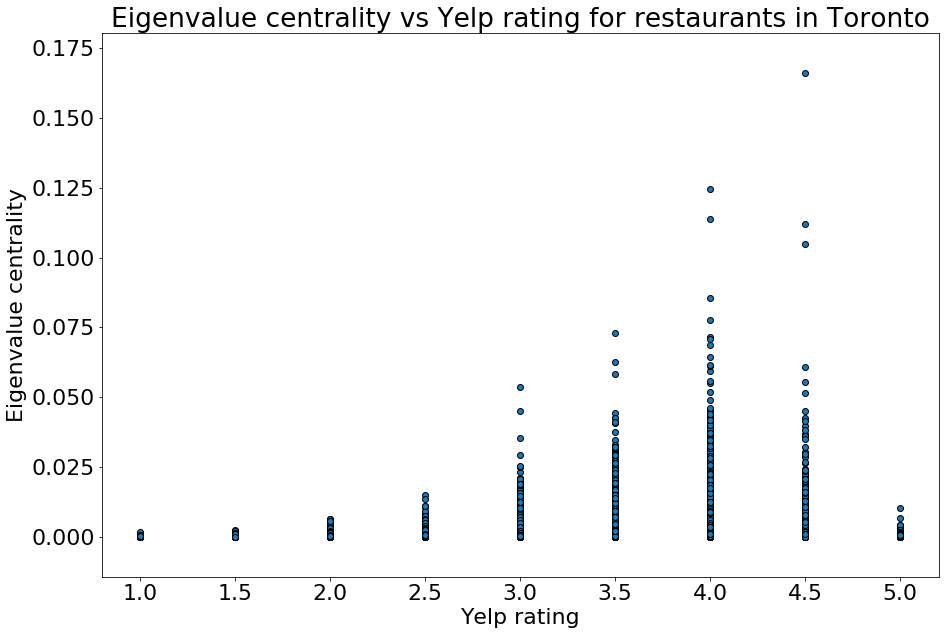

In [24]:
plt.figure(figsize=[15,10])
plt.scatter(biz.stars, biz.ev, edgecolors='black')
plt.xlabel('Yelp rating')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality vs Yelp rating for restaurants in Toronto')
plt.savefig('plots/biz_rating_ev.svg', format='svg', bbox_inches="tight")
plt.show()

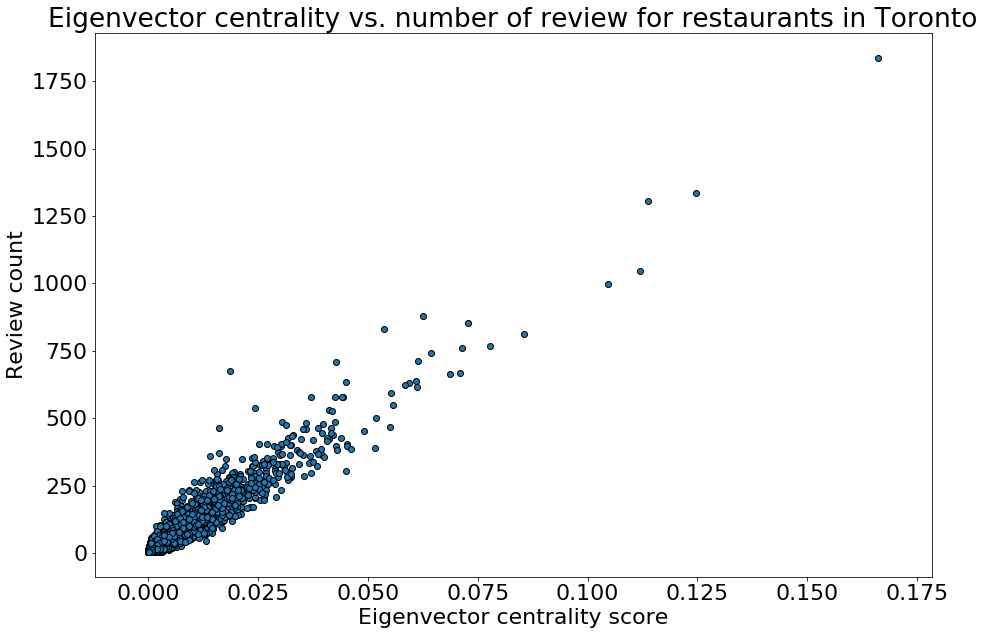

In [25]:
plt.figure(figsize=[15,10])
plt.scatter(biz.ev, biz.review_count, edgecolors='black')
plt.xlabel('Eigenvector centrality score')
plt.ylabel('Review count')
plt.title('Eigenvector centrality vs. number of review for restaurants in Toronto')
plt.savefig('plots/biz_ev_count.svg', format='svg', bbox_inches="tight")
plt.show()

### Review differences
For this section, the differences in ratings between the regular users and the elite users were investigated. 

#### Overall rating distributions
Are elite users overall harsher in their reviews? Or is it the other way around? Let us find out!

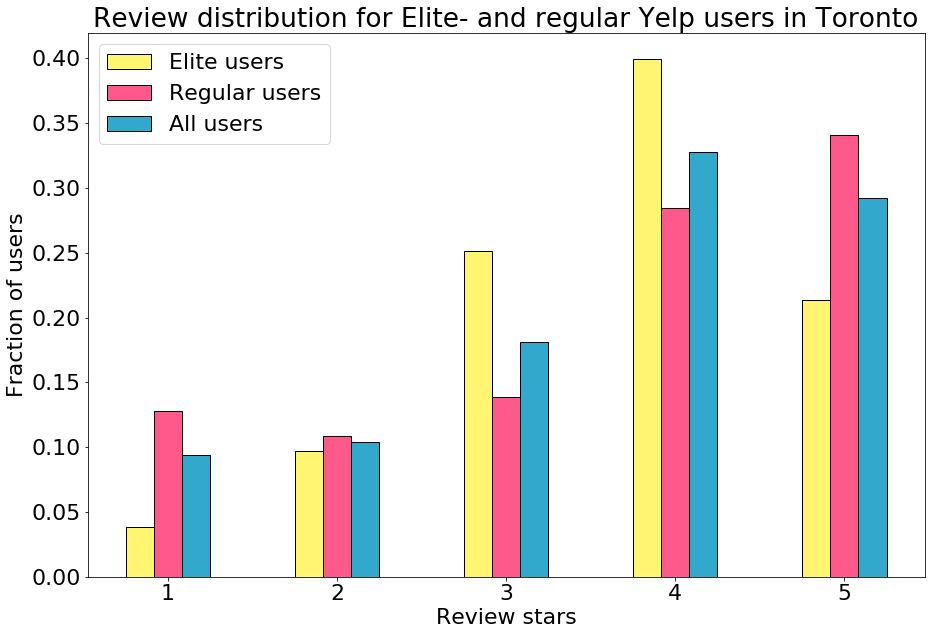

In [26]:
# Extract ratings for elite, regular, and all users
elite_stars = np.array(reviews[reviews.user_id.isin(elite_user.user_id)].stars)
regular_stars = np.array(reviews[~reviews.user_id.isin(elite_user.user_id)].stars)
all_stars = np.array(reviews.stars)

# Histogram data for regular users ratings
reg = np.histogram(regular_stars, bins=[1,2,3,4,5,6])[0]
reg = reg / sum(reg)

# Histogram data for elite users ratings
elit = np.histogram(elite_stars, bins=[1,2,3,4,5,6])[0]
elit = elit / sum(elit)

# Histogram data for all users ratings
all_ = np.histogram(all_stars, bins=[1,2,3,4,5,6])[0]
all_ = all_ / sum(all_)

# Plot the histogram data
plt.figure(figsize=[15,10])
x = np.array([1,2,3,4,5])
dx = 1/12 # x-axis space
plt.bar(x - 2*dx, height=elit, width=2*dx, color='#FFF571', edgecolor='black')
plt.bar(x, height=reg, width=2*dx, color='#FF588A', edgecolor='black')
plt.bar(x + 2*dx, height=all_, width=2*dx, color='#32A9CC', edgecolor='black')
plt.xlabel('Review stars')
plt.ylabel('Fraction of users')
plt.legend(['Elite users', 'Regular users', 'All users'])
plt.title('Review distribution for Elite- and regular Yelp users in Toronto')
plt.savefig('plots/review_dist.svg', format='svg', bbox_inches="tight")
plt.show()

Elite users are more moderate and peak at 4 stars, where regular users are more critical and over-enthustiastic, i.e. giving 1 star reviews, and 5 star reviews.

#### Concrete differences in ratings
Are elite users harsher in their reviews? Or is it the other way around? Let us find out!

In [27]:
# Get ids of businesses
biz_ids = [b.Data for b in review_biz_nodes]

# Only regular user reviews
reg_biz_graph = nx.subgraph(review_network, review_user_nodes + review_biz_nodes)
reg_weights_dict = reg_biz_graph.degree(review_biz_nodes, weight='weight')
reg_degrees_dict = reg_biz_graph.degree(review_biz_nodes)
reg_biz_ratings_dict = {
    node.Data: reg_weights_dict[node] / reg_degrees_dict[node] 
    for node in review_biz_nodes
    if reg_degrees_dict[node] > 0
}

# Only elite reviews
elite_biz_graph = nx.subgraph(review_network, review_elite_nodes + review_biz_nodes)
elite_weights_dict = elite_biz_graph.degree(review_biz_nodes, weight='weight')
elite_degrees_dict = elite_biz_graph.degree(review_biz_nodes)
elite_biz_ratings_dict = {
    node.Data: elite_weights_dict[node] / elite_degrees_dict[node]
    for node in review_biz_nodes
    if elite_degrees_dict[node] > 0
}

# All user reviews
all_weights_dict = review_network.degree(review_biz_nodes, weight='weight')
all_degrees_dict = review_network.degree(review_biz_nodes)
all_biz_ratings_dict = {
    node.Data: all_weights_dict[node] / all_degrees_dict[node] 
    for node in review_biz_nodes
    if all_degrees_dict[node] > 0
}

In [28]:
# Comparison REGULAR AND ELITE
deltas_elite_reg = {
    biz_id: elite_biz_ratings_dict[biz_id] - reg_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in reg_biz_ratings_dict.keys()
    and biz_id in elite_biz_ratings_dict.keys()
}

# Comparison ALL AND ELITE
deltas_elite_all = {
    biz_id: elite_biz_ratings_dict[biz_id] - all_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in all_biz_ratings_dict.keys()
    and biz_id in elite_biz_ratings_dict.keys()
}

# Comparison ALL AND REG
deltas_reg_all = {
    biz_id: reg_biz_ratings_dict[biz_id] - all_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in all_biz_ratings_dict.keys()
    and biz_id in reg_biz_ratings_dict.keys()
}

#### Elite-user ratings vs all user ratings

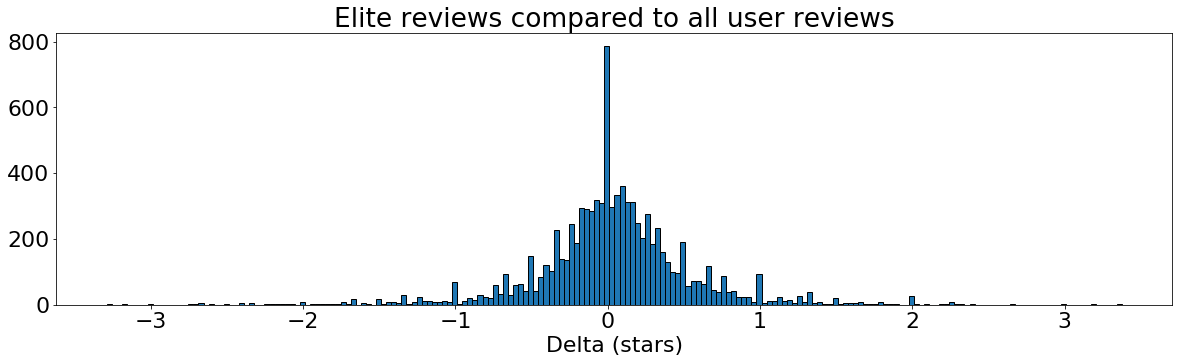

In [29]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_elite_all.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Elite reviews compared to all user reviews')
plt.savefig('plots/delta_elite_all.svg', format='svg', bbox_inches="tight")
plt.show()

#### Elite-user ratings vs regular user ratings

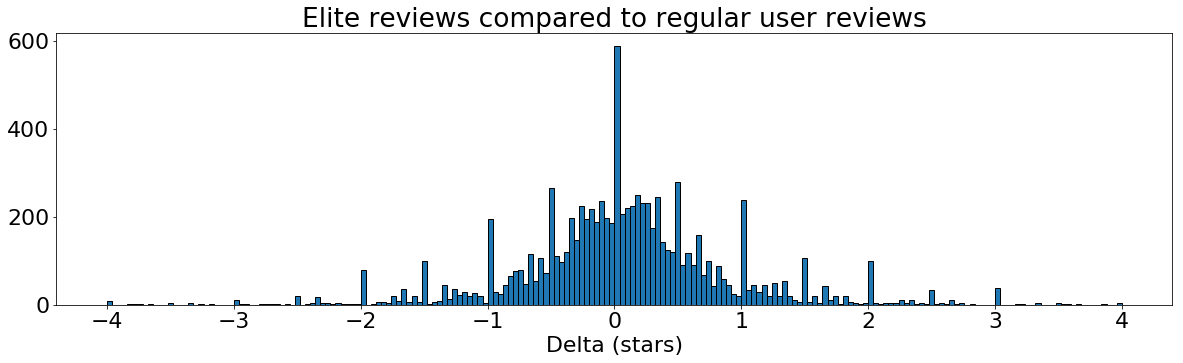

In [30]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_elite_reg.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Elite reviews compared to regular user reviews')
plt.savefig('plots/delta_elite_reg.svg', format='svg', bbox_inches="tight")
plt.show()

#### Regular user ratings vs all user ratings

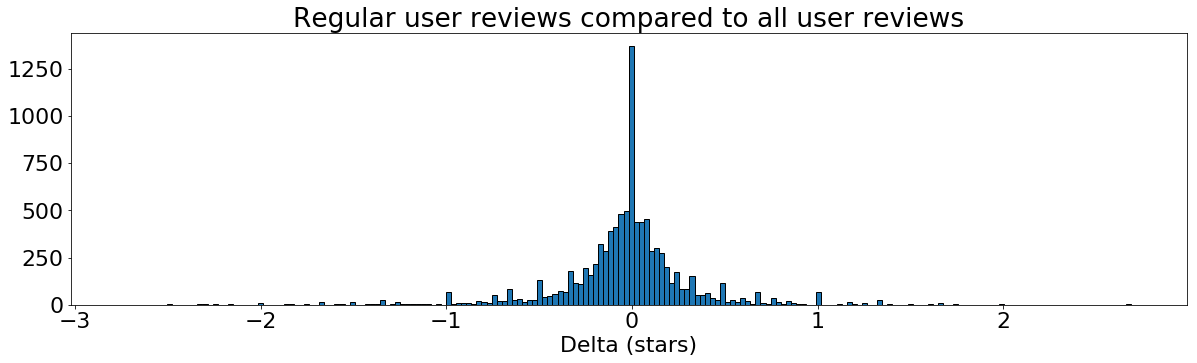

In [31]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_reg_all.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Regular user reviews compared to all user reviews')
plt.savefig('plots/delta_all_reg.svg', format='svg', bbox_inches="tight")
plt.show()

### Text Analysis

* **Talk about how you've worked with text, including regular expressions, unicode, etc.**

* **Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.**

* **How did you use the tools to understand your dataset?**

A variety of tools went into our text analysis. The review text was already nicely given to us in the data provided by yelp and so there was no need to use regular expressions or be concerned about unicode in order to acquire the relevant text.First, the *langdetect* package was used to filter out the small portion of reviews not written in english (mostly written in French as Toronto is in Canada).

Still, the reviews contained many misspellings and slang which led to uninformative results., So, comparing words to the set of english words provided by the *nltk* package was used to further filter out non-english words. That set of words does not include the conjugated forms, however, and so, each word was additionally stemmed using the *SnowballStemmer* or *WordNetLemmatizer* provided by *nltk* in order to better not lose the conjugated forms. Running this pipeline for all of the words across all of the reviews, we were able to create counts of words for each tier of stars and across elite and regular users, ten total documents.

For each of the words in a document, a TF-IDF score was generated as follows:


$TFIDF(word, document) = TF(word, document) * IDF(word)$ \\

$TF(word, document) = \text{frequency of word in document}$ \\

$IDF(word) = log(\frac{\#\text{ documents}}{\text{# documents containing word}})$

These TF-IDF scores were then used to generate wordclouds through the $\textit{wordcloud}$ package.

As each word was analyzed, we also generated a sentiment score for that word. The sentiment score came from the labMT 1.0 data from the Mechanical Turk study which contains 10,222 words and their evaluated average happiness score (Dodds, et al.). Storing the sentiment scores in each review allowed us to generate the graphs shown.

As the reviews were parsed, simple additional statistics such as review length were stored and averaged to create the other figures.

** References **

Dodds PS, Harris KD, Kloumann IM, Bliss CA, Danforth CM (2011) Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. PLoS ONE 6(12): e26752. https://doi.org/10.1371/journal.pone.0026752

## Discussion. Think critically about your creation
### What went well?
* Cleaning the dataset
* Analysing the social network
* Text analysis

The dataset was quite large, and thus we faced many issues in cleaning and preprocessing it. However, we managed to effectively parse out what we needed and collapse the data into a manageable subset. There is also so much potential for the data and we were able to come up with a couple of key questions to address.

For the text analysis, we managed to effectively filter the data and remove reviews written in foreign languages as well as filter out non-English words which were mostly misspellings and cluttered the word clouds. This required finding and implementing various lemmatizers and toolboxes until the text had been effectively filtered. Additionally, there was a lot of data to be reviewed and working with it all in memory was very slow. So, a strategy to periodically store the data, merging it with previously stored data, was employed.

### What is still missing? What could be improved?

The Review network is still slightly inconclusive. We had hoped that a better analysis would come of it. An idea we would like to try but requires taking a subgraph of the graph is making a review graph based on users who reviewed the same restaurant.

Additionally, more could be done with the text analysis. Further filtering could be done to potentially show more interesting results. Some words appeared very prominently in the word clouds but did not have an obvious reason for appearing. Upon further research, some of these words were found to correspond to single establishments and unique events of theirs. This clutters the word clouds but also is an interesting result that may benefit from additional analysis.